In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [4]:
state = 'NorthernMarianaIslands'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_daily = df[df['Entity']=='Northern Mariana Islands']['people_vaccinated'].to_numpy().reshape(-1,1)


In [5]:
df['Entity'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'Bureau of Prisons', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'Dept of Defense', 'District of Columbia',
       'Federated States of Micronesia', 'Florida', 'Georgia', 'Guam',
       'Hawaii', 'Idaho', 'Illinois', 'Indian Health Svc', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Long Term Care', 'Louisiana',
       'Maine', 'Marshall Islands', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York State', 'North Carolina', 'North Dakota',
       'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Republic of Palau', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
       'United States', 'Utah', 'Vermont', 'Veterans Health',
       'Virgin Islands', 'Virginia', 'Washington', 'West V

States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

# Preprocessing Data

In [6]:
scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
vaccines_cumulative_normalized = scaler.fit_transform(vaccines_daily)

In [7]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [8]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_cumulative_normalized,window_size)
split = int(len(X) * 0.7)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Cumulative + Non-Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Cumulative + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# Non-Cumulative + Non-Normalized
y_test_daily_vaccines = cumulative_to_daily(y_test_inverse)


In [9]:
y_test_inverse.shape

(25, 1)

# TST Model

In [10]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=512, n_heads=8, n_hidden=512, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}_Vaccine'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.2789183370769024
Epoch 2 Loss is 0.2777082696557045
Epoch 3 Loss is 0.095216765999794
Epoch 4 Loss is 0.06974666006863117
Epoch 5 Loss is 0.13151158019900322
Epoch 6 Loss is 0.10836593434214592
Epoch 7 Loss is 0.04609725810587406
Epoch 8 Loss is 0.03861808031797409
Epoch 9 Loss is 0.0501598734408617
Epoch 10 Loss is 0.027450927533209324
Epoch 11 Loss is 0.02111885044723749
Epoch 12 Loss is 0.0328491535037756
Epoch 13 Loss is 0.020618777722120285
Epoch 14 Loss is 0.017593412660062313
Epoch 15 Loss is 0.023933847434818745
Epoch 16 Loss is 0.01298834616318345
Epoch 17 Loss is 0.014313049148768187
Epoch 18 Loss is 0.01834651594981551
Epoch 19 Loss is 0.009858992882072926
Epoch 20 Loss is 0.013544532470405102
Epoch 21 Loss is 0.013798500411212444
Epoch 22 Loss is 0.007184361340478063
Epoch 23 Loss is 0.01289778109639883
Epoch 24 Loss is 0.011638870928436518
Epoch 25 Loss is 0.008388189598917961
Epoch 26 Loss is 0.011843765852972865
Epoch 27 Loss is 0.010357980616390705
Epo

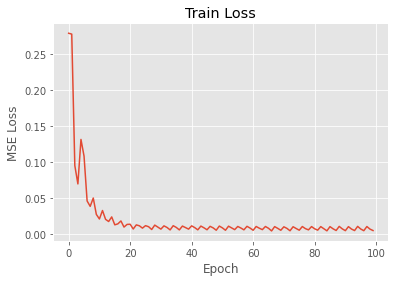

In [11]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [12]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test)

TST: Test MSE Loss:  0.005532143171876669


In [13]:
X_train[-1].shape

torch.Size([30, 1])

In [14]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [15]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 12625409 Parameters for the transformer model


In [16]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST.cpu().detach().numpy())
forecasted_daily_vaccines_TST  = cumulative_to_daily(forecasted_inverse_TST)

In [17]:
print('R2 Score for Vaccines',r2_score(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))

R2 Score for Vaccines 0.44397695071329724
MAPE Score for Vaccines 0.0707262


# LSTM Model

In [18]:
LSTM_model = COVID_LSTM(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}_Vaccine'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.09955871477723122
Epoch 2 Loss is 0.09634960442781448
Epoch 3 Loss is 0.09233305230736732
Epoch 4 Loss is 0.08746355026960373
Epoch 5 Loss is 0.08299097418785095
Epoch 6 Loss is 0.08296086266636848
Epoch 7 Loss is 0.07842816784977913
Epoch 8 Loss is 0.07926646620035172
Epoch 9 Loss is 0.07639988511800766
Epoch 10 Loss is 0.07551166042685509
Epoch 11 Loss is 0.07522276043891907
Epoch 12 Loss is 0.0746099054813385
Epoch 13 Loss is 0.07463103160262108
Epoch 14 Loss is 0.07575937733054161
Epoch 15 Loss is 0.0726166944950819
Epoch 16 Loss is 0.07331079244613647
Epoch 17 Loss is 0.0706909354776144
Epoch 18 Loss is 0.07107198238372803
Epoch 19 Loss is 0.07165532372891903
Epoch 20 Loss is 0.07081899419426918
Epoch 21 Loss is 0.06786904111504555
Epoch 22 Loss is 0.06718616560101509
Epoch 23 Loss is 0.06426551379263401
Epoch 24 Loss is 0.06143702194094658
Epoch 25 Loss is 0.0594815369695425
Epoch 26 Loss is 0.056148722767829895
Epoch 27 Loss is 0.05280904285609722
Epoch 28 Loss

In [19]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test)

LSTM: Test MSE Loss:  0.006927695125341415


In [20]:
X_test.shape

torch.Size([25, 30, 1])

In [21]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [22]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM.cpu().detach().numpy())
forecasted_daily_vaccines_LSTM  = cumulative_to_daily(forecasted_inverse_LSTM)

In [23]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))

R2 Score for Vaccines 0.9992234591988157
MAPE Score for Vaccines 5.188147e+16


# GRU Model

In [24]:
GRU_model = COVID_GRU(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}_Vaccine'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.09750622883439064
Epoch 2 Loss is 0.08450994826853275
Epoch 3 Loss is 0.07813413999974728
Epoch 4 Loss is 0.0743112675845623
Epoch 5 Loss is 0.07304168120026588
Epoch 6 Loss is 0.0693303756415844
Epoch 7 Loss is 0.06785169988870621
Epoch 8 Loss is 0.06658090837299824
Epoch 9 Loss is 0.0628650113940239
Epoch 10 Loss is 0.05871937796473503
Epoch 11 Loss is 0.0557656642049551
Epoch 12 Loss is 0.05181672424077988
Epoch 13 Loss is 0.04809745214879513
Epoch 14 Loss is 0.0430753119289875
Epoch 15 Loss is 0.03692292608320713
Epoch 16 Loss is 0.030752113088965416
Epoch 17 Loss is 0.024051920510828495
Epoch 18 Loss is 0.017303597182035446
Epoch 19 Loss is 0.01065469952300191
Epoch 20 Loss is 0.004965026862919331
Epoch 21 Loss is 0.0012502457248046994
Epoch 22 Loss is 0.0005852765752933919
Epoch 23 Loss is 0.002309726784005761
Epoch 24 Loss is 0.00449980644043535
Epoch 25 Loss is 0.0049877408891916275
Epoch 26 Loss is 0.0035440929932519794
Epoch 27 Loss is 0.001899735420010984
E

In [25]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test)

GRU: Test MSE Loss:  0.009308605454862118


In [26]:
X_test.shape

torch.Size([25, 30, 1])

In [27]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [28]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU.cpu().detach().numpy())
forecasted_daily_vaccines_GRU  = cumulative_to_daily(forecasted_inverse_GRU)

In [29]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))

R2 Score for Vaccines 0.9990625995435273
MAPE Score for Vaccines 5.3142476e+16


# Plots

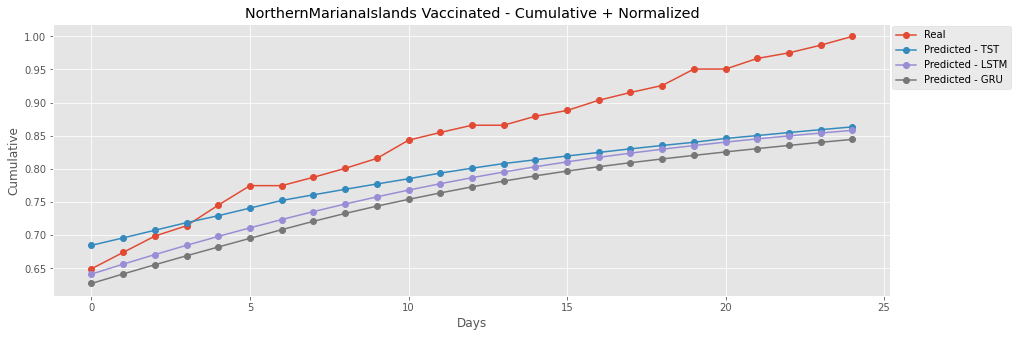

In [30]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0].cpu().detach().numpy(),label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0].cpu().detach().numpy(),label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0].cpu().detach().numpy(),label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

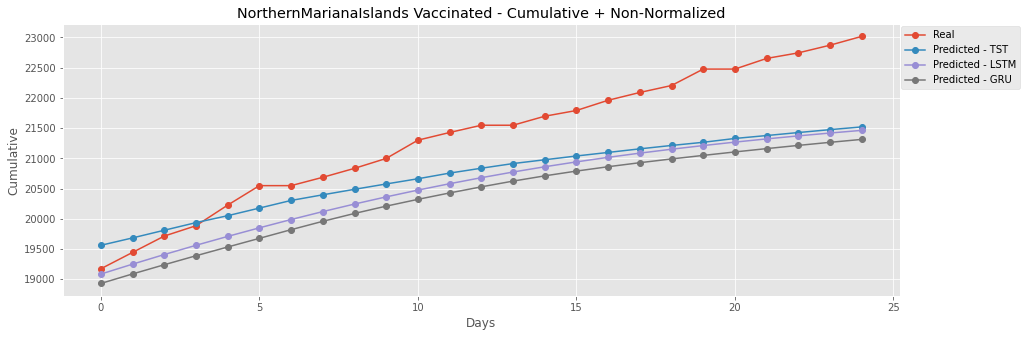

In [31]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()